In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import time
import os
from dataclasses import dataclass
from collections import namedtuple
import pyro
import optax
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import torch
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, softplus, grid_sample, affine_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import genjax
from genjax import grasp

key = jax.random.PRNGKey(314159)
console = genjax.pretty()
sns.set_theme(style="white")
# font_path = (
#     "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
# )
# font_manager.fontManager.addfont(font_path)
# custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
# rcParams["font.family"] = custom_font_name

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
label_fontsize = 70  # Set the desired font size here

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

In [2]:
%load_ext line_profiler

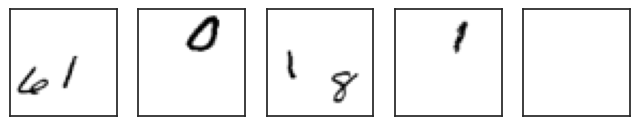

In [3]:
inpath = "./data/air/.data"
X_np, Y = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = jnp.array(X_np)
true_counts = jnp.array([len(objs) for objs in Y])


def show_images(imgs):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")


show_images(mnist[9:14])

## Defining the variational ingredients

### Utilities / learnable pieces

In [4]:
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

# Utilities for defining the model and the guide.


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(50, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 400, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)

# Create our RNN for the guide.
key, sub_key = jax.random.split(key)
rnn = eqx.nn.LSTMCell(2554, 256, key=sub_key)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(400, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 100, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:50], jax.nn.softplus(v[50:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@dataclass
class Predict(Pytree):
    dense: Any

    def flatten(self):
        return (self.dense,), ()

    @classmethod
    def new(cls, key):
        dense = eqx.nn.Linear(256, 7, key=key)
        return Predict(dense)

    def __call__(self, h):
        a = self.dense(h)
        z_pres_p = jax.nn.sigmoid(a[0:1])
        z_where_loc = a[1:4]
        z_where_scale = jax.nn.softplus(a[4:])
        return z_pres_p, z_where_loc, z_where_scale


key, sub_key = jax.random.split(key)
predict = Predict.new(key)

In [5]:
#######
# STN #
#######

# modified from https://github.com/kevinzakka/spatial-transformer-network/blob/master/stn/transformer.py


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.

    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.

    - width: desired width of grid/output. Used
      to downsample or upsample.

    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.

    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.

    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = theta.shape[0]

    # create normalized 2D grid
    x = jnp.linspace(-1.0, 1.0, width)
    y = jnp.linspace(-1.0, 1.0, height)
    x_t, y_t = jnp.meshgrid(x, y)

    # flatten
    x_t_flat = jnp.reshape(x_t, [-1])
    y_t_flat = jnp.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = jnp.ones_like(x_t_flat)
    sampling_grid = jnp.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = jnp.expand_dims(sampling_grid, axis=0)
    sampling_grid = jnp.tile(sampling_grid, [num_batch, 1, 1])

    # transform the sampling grid - batch multiply
    batch_grids = jnp.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, 2, H, W)
    batch_grids = jnp.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.

    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = jnp.shape(img)[1]
    W = jnp.shape(img)[2]
    max_y = H - 1
    max_x = W - 1
    zero = jnp.zeros([], dtype=int)

    # rescale x and y to [0, W-1/H-1]
    x = 0.5 * ((x + 1.0) * max_x - 1)
    y = 0.5 * ((y + 1.0) * max_y - 1)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = jnp.clip(x0, zero, max_x)
    x1 = jnp.clip(x1, zero, max_x)
    y0 = jnp.clip(y0, zero, max_y)
    y1 = jnp.clip(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = x0.astype(float)
    x1 = x1.astype(float)
    y0 = y0.astype(float)
    y1 = y1.astype(float)

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = jnp.expand_dims(wa, axis=3)
    wb = jnp.expand_dims(wb, axis=3)
    wc = jnp.expand_dims(wc, axis=3)
    wd = jnp.expand_dims(wd, axis=3)

    # compute output
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.

    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)

    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    batch_size, height, width = jnp.shape(x)

    batch_idx = jnp.arange(0, batch_size)
    batch_idx = jnp.reshape(batch_idx, (batch_size, 1, 1))
    b = jnp.tile(batch_idx, (1, height, width))

    indices = jnp.stack([b, y, x], 3)

    return gather_nd(img, indices)


# from: https://github.com/google/jax/discussions/6119
def gather_nd_unbatched(params, indices):
    return params[tuple(jnp.moveaxis(indices, -1, 0))]


def gather_nd(params, indices, batch=False):
    if not batch:
        return gather_nd_unbatched(params, indices)
    else:
        return vmap(gather_nd_unbatched, (0, 0), 0)(params, indices)


def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = 1
    expansion_indices = jnp.array([1, 0, 2, 0, 1, 3])
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.concatenate((jnp.broadcast_to(jnp.zeros([1, 1]), (n, 1)), z_where), 1)
    return jnp.reshape(out[:, expansion_indices], (n, 2, 3))


def object_to_image(z_where, obj):
    n = 1
    theta = expand_z_where(z_where)
    grid = affine_grid_generator(50, 50, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(obj, (n, 20, 20, 1)), x_s, y_s)
    return jnp.reshape(out, (50, 50))


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = 1
    out = jnp.array([1, *(-z_where[1:])])
    out = out / z_where[0]
    return out


def image_to_object(z_where, image):
    n = 1
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid_generator(20, 20, theta_inv)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(image, (n, 50, 50, 1)), x_s, y_s)
    return jnp.reshape(out, (400,))

### Model

In [6]:
#########
# Model #
#########

# Fixed constants.
z_where_prior_loc = jnp.array([3.0, 0.0, 0.0])
z_where_prior_scale = jnp.array([0.1, 1.0, 1.0])
z_what_prior_loc = jnp.zeros(50, dtype=float)
z_what_prior_scale = jnp.ones(50, dtype=float)


@genjax.gen
@typecheck
def step(
    t: Int,
    decoder: Decoder,
    prev_x: FloatArray,
    prev_z_pres: IntArray,
):
    z_pres = grasp.flip_enum(0.5 * prev_z_pres[0]) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = (
        grasp.mv_normal_diag_reparam(z_where_prior_loc, z_where_prior_scale)
        @ f"z_where_{t}"
    )
    z_what = (
        grasp.mv_normal_diag_reparam(z_what_prior_loc, z_what_prior_scale)
        @ f"z_what_{t}"
    )
    y_att = decoder(z_what)
    y = object_to_image(z_where, y_att)
    x = prev_x + (y * z_pres)
    return x, z_pres


# TODO: Make sure that this works, where t is a static int.
@genjax.gen
@typecheck
def model(decoder: Decoder):
    x = jnp.zeros((50, 50), dtype=float)
    z_pres = jnp.ones(1, dtype=int)
    for t in range(3):
        x, z_pres = step.inline(t, decoder, x, z_pres)
    obs = grasp.mv_normal_diag_reparam(x, 0.3 * jnp.ones_like(x)) @ "obs"
    return x

#### Samples from the model

In [7]:
tr = jax.jit(model.simulate)(key, (decoder,))
tr.strip()




├── :z_where_1
│   └──  f32[3]
├── :z_pres_1
│   └──  bool[]
├── :z_pres_2
│   └──  bool[]
├── :z_pres_0
│   └──  bool[]
├── :obs
│   └──  f32[50,50]
├── :z_where_2
│   └──  f32[3]
├── :z_where_0
│   └──  f32[3]
├── :z_what_2
│   └──  f32[50]
├── :z_what_1
│   └──  f32[50]
└── :z_what_0
    └──  f32[50]

### Guide

In [8]:
#########
# Guide #
#########


@genjax.gen
@typecheck
def guide_step(
    t: Int,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
    data,
    prev: Tuple,
):
    (prev_z_where, prev_z_what, prev_z_pres, prev_h, prev_c) = prev
    rnn_input = jnp.concatenate([data, prev_z_where, prev_z_what, prev_z_pres])
    h, c = rnn(rnn_input, (prev_h, prev_c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)
    z_pres = grasp.flip_enum(z_pres_p[0] * prev_z_pres[0]) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = grasp.mv_normal_diag_reparam(z_where_loc, z_where_scale) @ f"z_where_{t}"
    x_att = image_to_object(z_where, data)
    z_what_loc, z_what_scale = encoder(x_att)
    z_what = grasp.mv_normal_diag_reparam(z_what_loc, z_what_scale) @ f"z_what_{t}"
    return z_where, z_what, z_pres, h, c


@genjax.gen
@typecheck
def guide(
    data: genjax.ChoiceMap,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
):
    h = jnp.zeros(256)
    c = jnp.zeros(256)
    z_pres = jnp.ones(1)
    z_where = jnp.zeros(3)
    z_what = jnp.zeros(50)
    img = data["obs"]
    img_arr = img.flatten()

    for t in range(3):
        (z_where, z_what, z_pres, h, c) = guide_step.inline(
            t, rnn, encoder, predict, img_arr, (z_where, z_what, z_pres, h, c)
        )

#### Samples from the guide

In [9]:
data_chm = genjax.choice_map({"obs": jnp.ones((50, 50))})
tr = jax.jit(guide.simulate)(key, (data_chm, rnn, encoder, predict))
tr.strip()




├── :z_where_1
│   └──  f32[3]
├── :z_pres_1
│   └──  bool[]
├── :z_pres_2
│   └──  bool[]
├── :z_pres_0
│   └──  bool[]
├── :z_where_2
│   └──  f32[3]
├── :z_where_0
│   └──  f32[3]
├── :z_what_2
│   └──  f32[50]
├── :z_what_1
│   └──  f32[50]
└── :z_what_0
    └──  f32[50]

## Training

### Make sure grads are working

#### Define ELBO objective

In [10]:
data = genjax.choice_map({"obs": jnp.ones((50, 50))})
objective = grasp.elbo(model, guide, data)

#### Go go grads

In [11]:
jitted = jax.jit(objective.value_and_grad_estimate)
loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
    key, ((decoder,), (data, rnn, encoder, predict))
)

In [12]:
loss

Array(-9799.29, dtype=float32)

### Dataloader

In [13]:
def generators(
    data,
    split="train",
    shuffle=True,
):
    num_records = len(data[0])
    batch_size = num_records
    idxs = np.arange(num_records)

    def init():
        return (
            num_records // batch_size,
            np.random.permutation(idxs) if shuffle else idxs,
        )

    def get_batch(i=0, idxs=idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return tuple(
            np.take(a, ret_idx, axis=0)
            if isinstance(a, list)
            else jax.lax.index_take(a, (ret_idx,), axes=(0,))
            for a in data
        )

    return init, get_batch


def circular_data_loader(data, batch_size):
    M, N, H = data.shape
    num_complete_batches, leftover = divmod(M, batch_size)

    # Start with the complete batches
    batches = [
        data[i * batch_size : (i + 1) * batch_size] for i in range(num_complete_batches)
    ]

    # Handle the last batch if there's a leftover
    if leftover:
        last_batch = jnp.concatenate(
            [data[-leftover:], data[: batch_size - leftover]], axis=0
        )
        batches.append(last_batch)

    return generators(batches)

In [14]:
##################
# Count Accuracy #
##################
def count_accuracy(data, true_counts, guide, batch_size=1000):
    global prng_key
    assert data.shape[0] == true_counts.shape[0], "Size mismatch."
    assert data.shape[0] % batch_size == 0, "Input size must be multiple of batch_size."

    def eval_guide(key, data, params):
        data_chmp = genjax.choice_map({"obs": data})
        return guide.simulate(key, (data_chmp, *params))

    batch_eval_guide = jax.jit(jax.vmap(eval_guide, in_axes=(0, 0, None)))

    @jax.jit
    def evaluate_count_accuracy(key, params):
        def evaluate_batch(counts, batch_id):
            data_batch = jax.lax.dynamic_slice_in_dim(
                data, batch_id * batch_size, batch_size
            )
            true_counts_batch = jax.lax.dynamic_slice_in_dim(
                true_counts, batch_id * batch_size, batch_size
            )
            data_chmp = genjax.choice_map({"obs": data_batch})
            # evaluate guide
            keys = jax.random.split(jax.random.fold_in(key, batch_id), batch_size)
            tr = batch_eval_guide(keys, data_batch, params)
            z_where = [tr[f"z_where_{i}"] for i in range(3)]
            z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
            # compute stats
            inferred_counts = sum(z for z in z_pres)
            true_counts_m = jax.nn.one_hot(true_counts_batch, 3)
            inferred_counts_m = jax.nn.one_hot(inferred_counts, 4)
            counts += (true_counts_m.T @ inferred_counts_m).astype(int)
            error_ind = 1 - (true_counts_batch == inferred_counts).astype(int)
            # error_ix = error_ind.nonzero()[0]
            # error_latent = jnp.take(latents_to_tensor((z_where, z_pres)), error_ix, 0)
            return counts, error_ind

        counts = jnp.zeros((3, 4), dtype=int)
        counts, error_indices = jax.lax.scan(
            evaluate_batch, counts, jnp.arange(data.shape[0] // batch_size)
        )

        acc = jnp.sum(jnp.diag(counts)).astype(float) / data.shape[0]
        error_indices = jnp.concatenate(
            error_indices
        )  # .nonzero()[0]  # <- not JIT compilable
        return acc, counts, error_indices

    return evaluate_count_accuracy


# Combine z_pres and z_where (as returned by the model and guide) into
# a single tensor, with size:
# [batch_size, num_steps, z_where_size + z_pres_size]
def latents_to_tensor(z):
    return jnp.stack(
        [
            jnp.concatenate((z_where, z_pres.reshape(-1, 1)), 1)
            for z_where, z_pres in zip(*z)
        ]
    ).transpose(1, 0, 2)

In [15]:
##################
# Visualization  #
##################
def bounding_box(z_where, x_size):
    """This doesn't take into account interpolation, but it's close
    enough to be usable."""
    w = x_size / z_where.s
    h = x_size / z_where.s
    xtrans = -z_where.x / z_where.s * x_size / 2.0
    ytrans = -z_where.y / z_where.s * x_size / 2.0
    x = (x_size - w) / 2 + xtrans  # origin is top left
    y = (x_size - h) / 2 + ytrans
    return (x, y), w, h


z_obj = namedtuple("z", ["s", "x", "y", "pres"])


# Map a tensor of latents (as produced by latents_to_tensor) to a list
# of z_obj named tuples.
def tensor_to_objs(latents):
    return [[z_obj._make(step) for step in z] for z in latents]


def visualize_model(model, guide):
    def reconstruct_digits(key, data, params):
        decoder, rnn, encoder, predict = params
        data_chmp = genjax.choice_map({"obs": data})
        key1, key2 = jax.random.split(key)
        tr = guide.simulate(key1, (data_chmp, rnn, encoder, predict))
        _, tr = model.importance(key2, tr, (decoder,))
        reconstruction = tr.get_retval()
        z_where = [tr[f"z_where_{i}"] for i in range(3)]
        z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
        return reconstruction, (z_where, z_pres)

    batch_reconstruct_digits = jax.jit(
        jax.vmap(reconstruct_digits, in_axes=(0, 0, None))
    )

    def visualize(key, params, examples_to_viz):
        keys = jax.random.split(key, examples_to_viz.shape[0])
        recons, z = batch_reconstruct_digits(keys, examples_to_viz, params)
        z_wheres = tensor_to_objs(latents_to_tensor(z))
        draw_many(examples_to_viz.reshape(-1, 50, 50), z_wheres, title="Original")
        draw_many(recons, z_wheres, title="Reconstruction")

    return visualize


def colors(k):
    return ["r", "g", "b"][k % 3]


def draw_one(img, z):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray_r")
    for k, z in enumerate(z):
        if z.pres > 0:
            (x, y), w, h = bounding_box(z, img.shape[0])
            plt.gca().add_patch(
                Rectangle(
                    (x, y), w, h, linewidth=1, edgecolor=colors(k), facecolor="none"
                )
            )


def draw_many(imgs, zs, title):
    plt.figure(figsize=(8, 1.9))
    plt.title(title)
    plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.box(False)
    for i, (img, z) in enumerate(zip(imgs, zs)):
        plt.subplot(1, len(imgs), i + 1)
        draw_one(img, z)
    plt.show()

In [16]:
params = (decoder, rnn, encoder, predict)
evaluate_accuracy = count_accuracy(mnist, true_counts, guide, batch_size=1000)

visualize_examples = mnist[5:10]
visualize = visualize_model(model, guide)

Epoch=0, elapsed=22.52, loss=-4244.81
accuracy=0.2931666672229767, counts=[[10255  4930  2423  2340]
 [10750  5079  2265  1926]
 [10954  5186  2256  1636]]


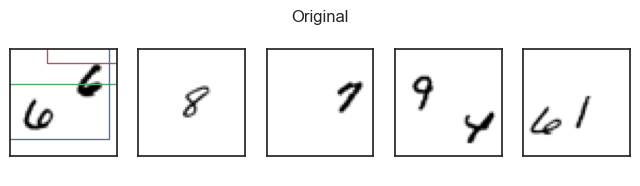

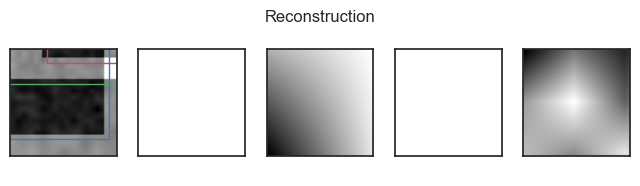

Epoch=100, elapsed=48.27, loss=378.47
accuracy=0.21095000207424164, counts=[[11577  7854   514     3]
 [18925  1080    14     1]
 [19791   241     0     0]]
Epoch=200, elapsed=67.03, loss=386.18
accuracy=0.21889999508857727, counts=[[12040  7376   525     7]
 [18911  1094    15     0]
 [19778   254     0     0]]
Epoch=300, elapsed=85.86, loss=428.38
accuracy=0.22985000908374786, counts=[[12682  6779   466    21]
 [18900  1106    13     1]
 [19713   316     3     0]]
Epoch=400, elapsed=104.80, loss=463.56
accuracy=0.2395000010728836, counts=[[13309  6130   495    14]
 [18937  1060    23     0]
 [19731   300     1     0]]
Epoch=500, elapsed=123.78, loss=465.66
accuracy=0.24469999969005585, counts=[[13591  5944   399    14]
 [18919  1090    11     0]
 [19707   324     1     0]]
Epoch=600, elapsed=142.77, loss=466.62
accuracy=0.25091665983200073, counts=[[14043  5564   330    11]
 [18992  1011    17     0]
 [19689   342     1     0]]
Epoch=700, elapsed=161.74, loss=465.39
accuracy=0.253116

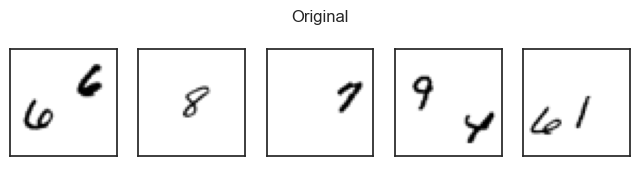

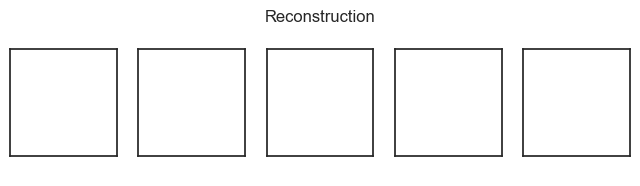

Epoch=1100, elapsed=238.65, loss=468.34
accuracy=0.26561665534973145, counts=[[15026  4673   245     4]
 [19098   909    13     0]
 [19729   301     2     0]]
Epoch=1200, elapsed=257.96, loss=468.25
accuracy=0.26991668343544006, counts=[[15283  4437   222     6]
 [19095   910    15     0]
 [19741   289     2     0]]
Epoch=1300, elapsed=277.16, loss=468.44
accuracy=0.2736000120639801, counts=[[15471  4256   218     3]
 [19064   945    11     0]
 [19712   320     0     0]]
Epoch=1400, elapsed=296.47, loss=468.29
accuracy=0.2759833335876465, counts=[[15604  4146   197     1]
 [19050   952    18     0]
 [19726   303     3     0]]
Epoch=1500, elapsed=315.78, loss=468.23
accuracy=0.27630001306533813, counts=[[15587  4159   197     5]
 [19022   987    11     0]
 [19668   360     4     0]]
Epoch=1600, elapsed=335.10, loss=468.17
accuracy=0.2799333333969116, counts=[[15756  4013   169    10]
 [18967  1038    15     0]
 [19595   435     2     0]]
Epoch=1700, elapsed=354.34, loss=468.08
accuracy=

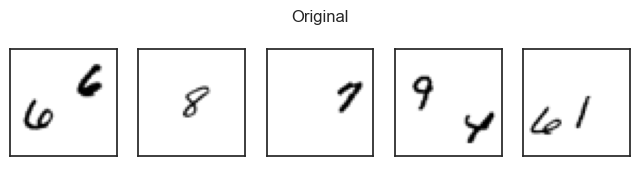

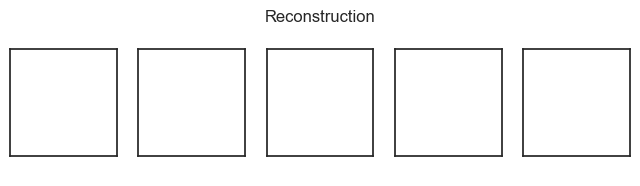

Epoch=2100, elapsed=431.77, loss=468.56
accuracy=0.29358333349227905, counts=[[15967  3708   264     9]
 [18347  1626    45     2]
 [19042   968    22     0]]
Epoch=2200, elapsed=451.46, loss=468.92
accuracy=0.2992333471775055, counts=[[16113  3601   229     5]
 [18150  1809    60     1]
 [18708  1291    32     1]]
Epoch=2300, elapsed=471.18, loss=468.66
accuracy=0.3067166805267334, counts=[[16011  3641   281    15]
 [17610  2300   103     7]
 [18161  1777    92     2]]
Epoch=2400, elapsed=490.57, loss=469.90
accuracy=0.3224666714668274, counts=[[15875  3694   353    26]
 [16545  3173   280    22]
 [16619  3083   300    30]]
Epoch=2500, elapsed=509.80, loss=471.15
accuracy=0.382750004529953, counts=[[15835  3453   581    79]
 [12492  4891  1769   868]
 [11153  5213  2239  1427]]
Epoch=2600, elapsed=528.99, loss=501.71
accuracy=0.27693334221839905, counts=[[15461  2633   811  1043]
 [ 2384   848   559 16229]
 [  709   344   307 18672]]
Epoch=2700, elapsed=548.21, loss=551.96
accuracy=0.

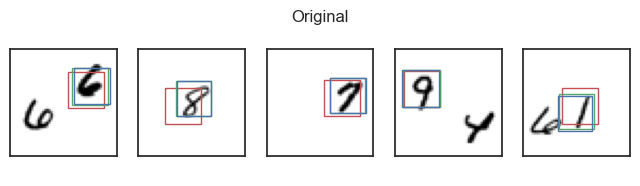

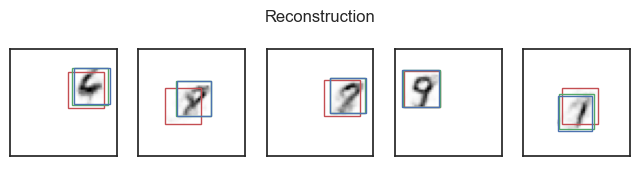

Epoch=3100, elapsed=625.25, loss=602.77
accuracy=0.31690001487731934, counts=[[18910   981    50     7]
 [  279   103    42 19596]
 [    5     2     1 20024]]
Epoch=3200, elapsed=644.46, loss=609.11
accuracy=0.3212999999523163, counts=[[19200   715    29     4]
 [  290    75    39 19616]
 [    4     0     3 20025]]
Epoch=3300, elapsed=663.30, loss=609.47
accuracy=0.3236333429813385, counts=[[19340   584    22     2]
 [  314    77    28 19601]
 [    9     1     1 20021]]
Epoch=3400, elapsed=682.49, loss=606.10
accuracy=0.3255999982357025, counts=[[19473   462    10     3]
 [  303    62    22 19633]
 [    6     0     1 20025]]
Epoch=3500, elapsed=701.76, loss=609.15
accuracy=0.3264833390712738, counts=[[19521   414    13     0]
 [  324    68    16 19612]
 [    7     1     0 20024]]
Epoch=3600, elapsed=721.07, loss=609.77
accuracy=0.3276166617870331, counts=[[19592   348     6     2]
 [  317    64    18 19621]
 [    2     0     1 20029]]
Epoch=3700, elapsed=740.35, loss=613.83
accuracy=0.

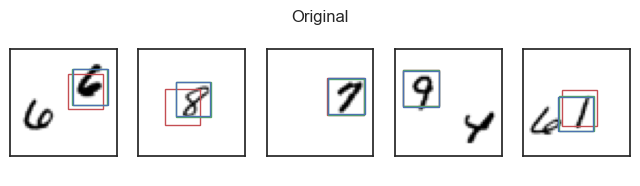

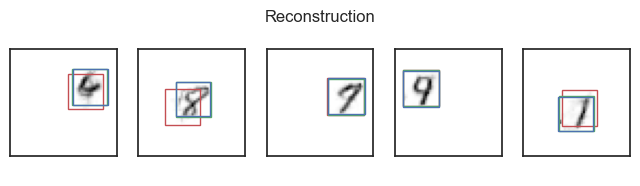

Epoch=4100, elapsed=817.31, loss=617.37
accuracy=0.3303833305835724, counts=[[19764   183     1     0]
 [  320    59    15 19626]
 [    2     0     0 20030]]
Epoch=4200, elapsed=836.48, loss=617.86
accuracy=0.3308166563510895, counts=[[19797   149     1     1]
 [  331    52     9 19628]
 [    2     0     0 20030]]
Epoch=4300, elapsed=855.63, loss=614.61
accuracy=0.330949991941452, counts=[[19790   154     3     1]
 [  338    67     9 19606]
 [    3     1     0 20028]]
Epoch=4400, elapsed=875.19, loss=612.66
accuracy=0.3310333490371704, counts=[[19819   128     1     0]
 [  295    42    21 19662]
 [    1     0     1 20030]]
Epoch=4500, elapsed=894.45, loss=619.27
accuracy=0.3307500183582306, counts=[[19820   125     2     1]
 [  320    25     9 19666]
 [    2     0     0 20030]]
Epoch=4600, elapsed=913.65, loss=618.06
accuracy=0.3314666748046875, counts=[[19856    90     2     0]
 [  312    30     9 19669]
 [    0     1     2 20029]]
Epoch=4700, elapsed=933.05, loss=617.12
accuracy=0.33

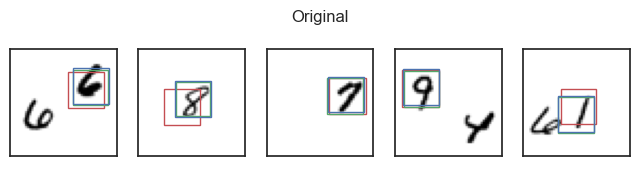

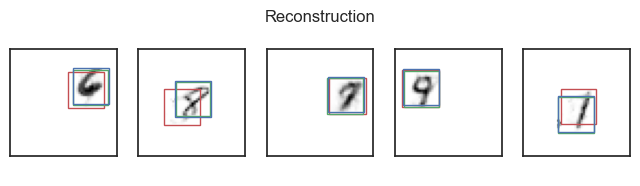

Epoch=5100, elapsed=1010.31, loss=620.96
accuracy=0.3316499888896942, counts=[[19871    75     2     0]
 [  288    28    11 19693]
 [    0     0     0 20032]]
Epoch=5200, elapsed=1029.61, loss=619.43
accuracy=0.3320000171661377, counts=[[19895    53     0     0]
 [  313    25    11 19671]
 [    1     0     0 20031]]
Epoch=5300, elapsed=1049.05, loss=619.70
accuracy=0.33195000886917114, counts=[[19891    56     0     1]
 [  324    26     8 19662]
 [    0     0     0 20032]]
Epoch=5400, elapsed=1068.66, loss=623.98
accuracy=0.33161666989326477, counts=[[19882    63     3     0]
 [  300    15    10 19695]
 [    0     0     0 20032]]
Epoch=5500, elapsed=1088.35, loss=621.84
accuracy=0.3319833278656006, counts=[[19889    59     0     0]
 [  306    29     1 19684]
 [    1     0     1 20030]]
Epoch=5600, elapsed=1107.57, loss=621.89
accuracy=0.3321833312511444, counts=[[19899    49     0     0]
 [  276    32     5 19707]
 [    0     0     0 20032]]
Epoch=5700, elapsed=1126.94, loss=622.41
acc

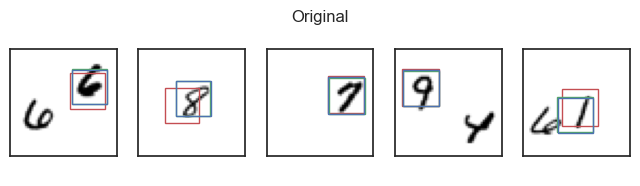

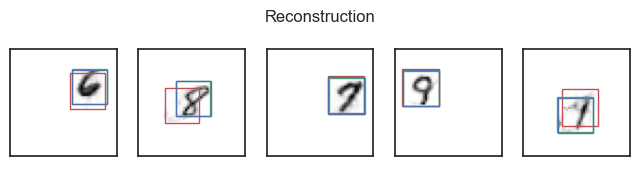

Epoch=6100, elapsed=1204.56, loss=622.10
accuracy=0.33250001072883606, counts=[[19915    33     0     0]
 [  275    35     2 19708]
 [    0     1     0 20031]]
Epoch=6200, elapsed=1224.02, loss=624.53
accuracy=0.33230000734329224, counts=[[19913    34     1     0]
 [  283    25     4 19708]
 [    0     0     0 20032]]
Epoch=6300, elapsed=1243.27, loss=625.39
accuracy=0.33246666193008423, counts=[[19928    19     1     0]
 [  273    20     5 19722]
 [    0     0     0 20032]]
Epoch=6400, elapsed=1262.53, loss=625.15
accuracy=0.3323500156402588, counts=[[19926    21     1     0]
 [  286    15     4 19715]
 [    3     0     0 20029]]
Epoch=6500, elapsed=1281.74, loss=622.80
accuracy=0.3322499990463257, counts=[[19915    33     0     0]
 [  271    20     0 19729]
 [    0     0     0 20032]]
Epoch=6600, elapsed=1300.92, loss=626.88
accuracy=0.33241668343544006, counts=[[19928    20     0     0]
 [  263    17     3 19737]
 [    0     0     0 20032]]
Epoch=6700, elapsed=1320.07, loss=626.25
a

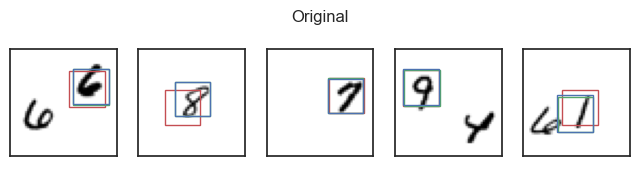

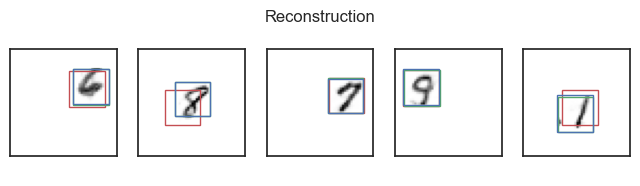

Epoch=7100, elapsed=1397.25, loss=627.88
accuracy=0.3323333263397217, counts=[[19928    20     0     0]
 [  264    12     4 19740]
 [    0     0     0 20032]]
Epoch=7200, elapsed=1416.51, loss=626.72
accuracy=0.33241668343544006, counts=[[19931    17     0     0]
 [  240    14     5 19761]
 [    0     0     0 20032]]
Epoch=7300, elapsed=1435.72, loss=626.24
accuracy=0.3325499892234802, counts=[[19931    17     0     0]
 [  251    22     1 19746]
 [    0     0     0 20032]]
Epoch=7400, elapsed=1454.96, loss=627.74
accuracy=0.33231666684150696, counts=[[19930    17     1     0]
 [  275     9     3 19733]
 [    1     0     0 20031]]
Epoch=7500, elapsed=1474.18, loss=626.27
accuracy=0.3323333263397217, counts=[[19927    20     1     0]
 [  237    12     3 19768]
 [    1     0     1 20030]]
Epoch=7600, elapsed=1493.38, loss=625.87
accuracy=0.33258333802223206, counts=[[19933    15     0     0]
 [  236    22     2 19760]
 [    0     0     0 20032]]
Epoch=7700, elapsed=1512.57, loss=628.30
ac

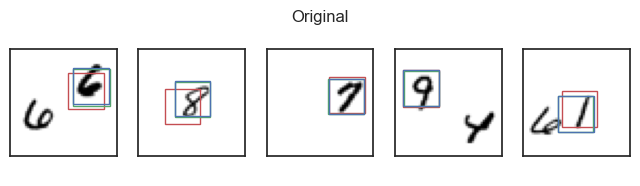

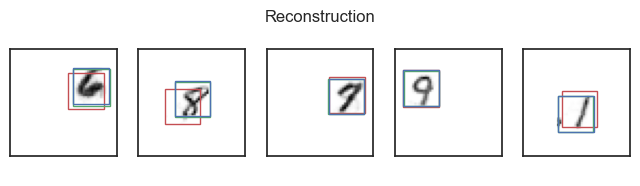

Epoch=8100, elapsed=1588.88, loss=627.96
accuracy=0.33256667852401733, counts=[[19940     8     0     0]
 [  239    14     2 19765]
 [    0     0     0 20032]]
Epoch=8200, elapsed=1607.61, loss=625.05
accuracy=0.33230000734329224, counts=[[19929    19     0     0]
 [  232     9     1 19778]
 [    0     0     0 20032]]
Epoch=8300, elapsed=1626.41, loss=627.87
accuracy=0.3324333429336548, counts=[[19941     7     0     0]
 [  238     5     2 19775]
 [    0     0     0 20032]]
Epoch=8400, elapsed=1645.28, loss=628.44
accuracy=0.33248335123062134, counts=[[19938    10     0     0]
 [  230    11     0 19779]
 [    0     0     0 20032]]
Epoch=8500, elapsed=1664.13, loss=629.22
accuracy=0.33239999413490295, counts=[[19939     9     0     0]
 [  208     5     1 19806]
 [    0     0     0 20032]]
Epoch=8600, elapsed=1682.85, loss=628.78
accuracy=0.3325499892234802, counts=[[19943     5     0     0]
 [  218     9     1 19792]
 [    1     0     1 20030]]
Epoch=8700, elapsed=1701.54, loss=629.14
a

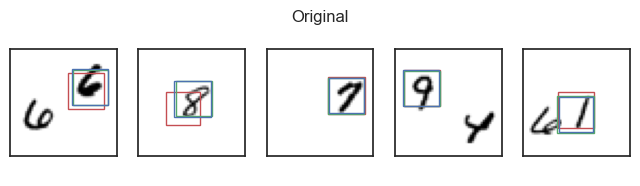

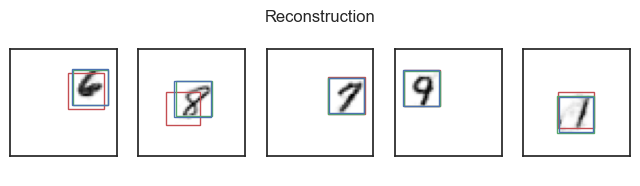

Epoch=9100, elapsed=1777.01, loss=629.56
accuracy=0.3324500024318695, counts=[[19941     7     0     0]
 [  198     6     4 19812]
 [    0     0     0 20032]]
Epoch=9200, elapsed=1795.92, loss=627.81
accuracy=0.3324500024318695, counts=[[19942     6     0     0]
 [  207     5     1 19807]
 [    0     0     0 20032]]
Epoch=9300, elapsed=1815.19, loss=629.18
accuracy=0.3323500156402588, counts=[[19936    12     0     0]
 [  220     5     1 19794]
 [    1     0     0 20031]]
Epoch=9400, elapsed=1834.29, loss=628.38
accuracy=0.33248335123062134, counts=[[19944     4     0     0]
 [  190     5     0 19825]
 [    0     0     0 20032]]
Epoch=9500, elapsed=1853.51, loss=626.12
accuracy=0.33239999413490295, counts=[[19941     7     0     0]
 [  193     3     0 19824]
 [    0     0     0 20032]]
Epoch=9600, elapsed=1872.66, loss=628.60
accuracy=0.33256667852401733, counts=[[19947     1     0     0]
 [  191     7     2 19820]
 [    0     0     0 20032]]
Epoch=9700, elapsed=1891.92, loss=629.75
ac

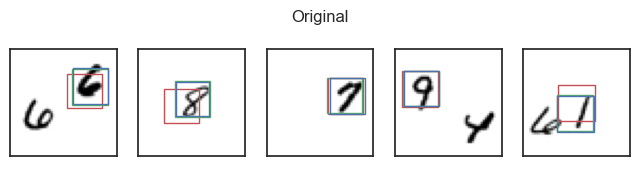

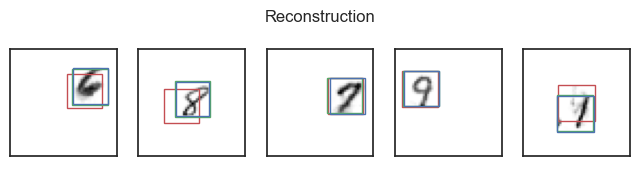

Epoch=10100, elapsed=1969.20, loss=627.28
accuracy=0.33248335123062134, counts=[[19943     5     0     0]
 [  172     6     0 19842]
 [    0     0     0 20032]]
Epoch=10200, elapsed=1988.43, loss=628.40
accuracy=0.3324333429336548, counts=[[19942     5     1     0]
 [  162     4     1 19853]
 [    0     0     0 20032]]
Epoch=10300, elapsed=2007.66, loss=628.92
accuracy=0.33238333463668823, counts=[[19938    10     0     0]
 [  188     5     1 19826]
 [    0     0     0 20032]]
Epoch=10400, elapsed=2026.93, loss=629.22
accuracy=0.33250001072883606, counts=[[19943     4     1     0]
 [  168     7     0 19845]
 [    0     0     0 20032]]
Epoch=10500, elapsed=2046.20, loss=630.03
accuracy=0.33248335123062134, counts=[[19946     2     0     0]
 [  162     3     0 19855]
 [    1     0     0 20031]]
Epoch=10600, elapsed=2065.39, loss=628.29
accuracy=0.3325166702270508, counts=[[19948     0     0     0]
 [  156     3     0 19861]
 [    0     0     0 20032]]
Epoch=10700, elapsed=2084.58, loss=6

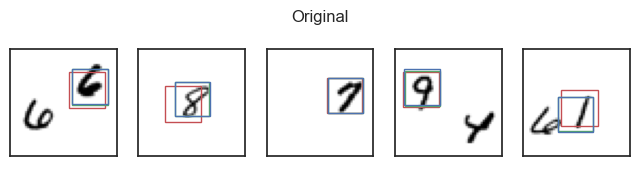

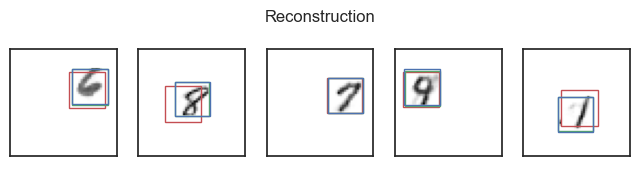

Epoch=11100, elapsed=2161.79, loss=629.12
accuracy=0.33248335123062134, counts=[[19945     3     0     0]
 [  150     4     0 19866]
 [    0     0     0 20032]]
Epoch=11200, elapsed=2181.03, loss=629.49
accuracy=0.33246666193008423, counts=[[19947     1     0     0]
 [  153     1     2 19864]
 [    0     0     0 20032]]
Epoch=11300, elapsed=2200.20, loss=628.83
accuracy=0.33241668343544006, counts=[[19944     3     1     0]
 [  155     1     0 19864]
 [    0     0     0 20032]]
Epoch=11400, elapsed=2219.38, loss=629.15
accuracy=0.3325333297252655, counts=[[19945     3     0     0]
 [  129     7     0 19884]
 [    0     0     0 20032]]
Epoch=11500, elapsed=2238.58, loss=631.17
accuracy=0.33248335123062134, counts=[[19945     3     0     0]
 [  145     4     0 19871]
 [    0     0     0 20032]]
Epoch=11600, elapsed=2257.76, loss=628.93
accuracy=0.33248335123062134, counts=[[19947     1     0     0]
 [  144     2     1 19873]
 [    0     0     0 20032]]
Epoch=11700, elapsed=2276.98, loss=

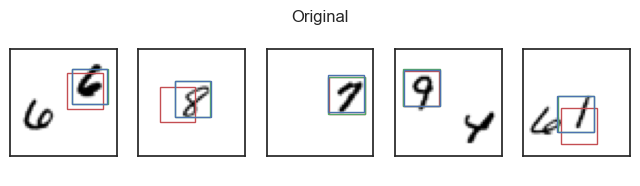

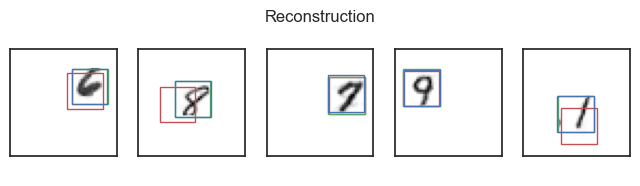

Epoch=12100, elapsed=2353.83, loss=629.64
accuracy=0.3324500024318695, counts=[[19947     0     1     0]
 [  127     0     1 19892]
 [    0     0     0 20032]]
Epoch=12200, elapsed=2372.99, loss=631.13
accuracy=0.33250001072883606, counts=[[19945     3     0     0]
 [  130     5     1 19884]
 [    0     0     0 20032]]
Epoch=12300, elapsed=2392.12, loss=629.01
accuracy=0.33246666193008423, counts=[[19946     2     0     0]
 [  125     2     0 19893]
 [    0     0     0 20032]]
Epoch=12400, elapsed=2411.26, loss=629.56
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [  129     1     1 19889]
 [    0     0     0 20032]]
Epoch=12500, elapsed=2430.40, loss=628.53
accuracy=0.33246666193008423, counts=[[19946     2     0     0]
 [  136     2     3 19879]
 [    0     0     0 20032]]
Epoch=12600, elapsed=2449.50, loss=630.10
accuracy=0.33246666193008423, counts=[[19947     1     0     0]
 [  136     1     1 19882]
 [    0     0     0 20032]]
Epoch=12700, elapsed=2468.58, loss=

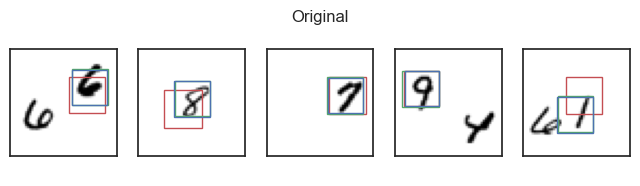

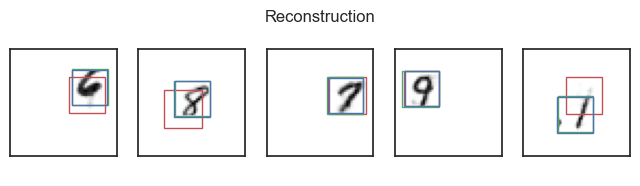

Epoch=13100, elapsed=2545.15, loss=630.91
accuracy=0.3325333297252655, counts=[[19947     1     0     0]
 [  121     5     1 19893]
 [    0     0     0 20032]]
Epoch=13200, elapsed=2564.25, loss=630.14
accuracy=0.3325166702270508, counts=[[19947     0     1     0]
 [  129     4     2 19885]
 [    0     0     0 20032]]
Epoch=13300, elapsed=2583.38, loss=629.43
accuracy=0.33250001072883606, counts=[[19947     1     0     0]
 [  126     3     0 19891]
 [    0     0     0 20032]]
Epoch=13400, elapsed=2602.47, loss=629.37
accuracy=0.33248335123062134, counts=[[19947     1     0     0]
 [  128     2     0 19890]
 [    0     0     0 20032]]
Epoch=13500, elapsed=2621.58, loss=631.58
accuracy=0.33246666193008423, counts=[[19948     0     0     0]
 [  135     0     0 19885]
 [    0     0     0 20032]]
Epoch=13600, elapsed=2640.76, loss=631.20
accuracy=0.33241668343544006, counts=[[19944     4     0     0]
 [  121     1     1 19897]
 [    0     0     0 20032]]
Epoch=13700, elapsed=2660.08, loss=6

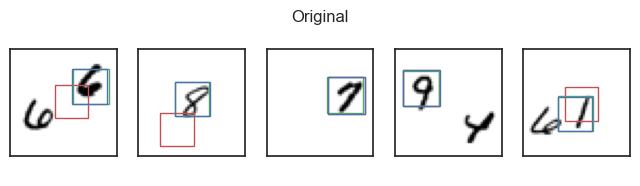

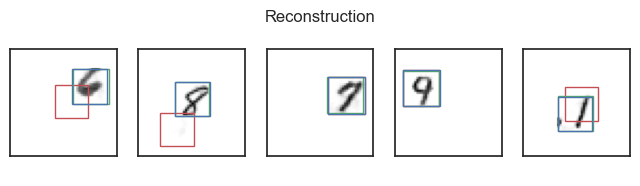

Epoch=14100, elapsed=2737.23, loss=629.59
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [  107     1     0 19912]
 [    0     0     0 20032]]
Epoch=14200, elapsed=2756.42, loss=628.02
accuracy=0.33246666193008423, counts=[[19947     1     0     0]
 [  117     1     0 19902]
 [    0     0     0 20032]]
Epoch=14300, elapsed=2775.66, loss=630.89
accuracy=0.33246666193008423, counts=[[19948     0     0     0]
 [  112     0     1 19907]
 [    0     0     0 20032]]
Epoch=14400, elapsed=2794.87, loss=629.66
accuracy=0.33250001072883606, counts=[[19948     0     0     0]
 [  109     2     1 19908]
 [    0     0     0 20032]]
Epoch=14500, elapsed=2814.05, loss=630.87
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [  116     1     1 19902]
 [    0     0     0 20032]]
Epoch=14600, elapsed=2833.29, loss=630.58
accuracy=0.33250001072883606, counts=[[19948     0     0     0]
 [  114     2     1 19903]
 [    0     0     0 20032]]
Epoch=14700, elapsed=2852.63, loss

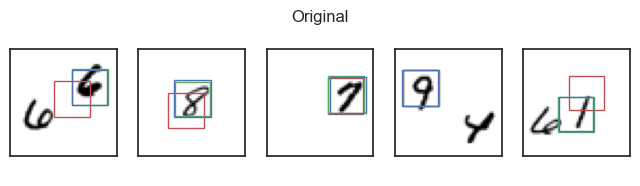

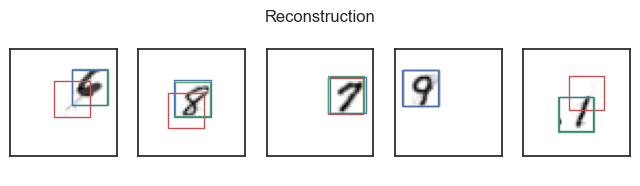

Epoch=15100, elapsed=2929.47, loss=632.06
accuracy=0.3325499892234802, counts=[[19947     1     0     0]
 [  102     6     1 19911]
 [    0     0     0 20032]]
Epoch=15200, elapsed=2948.62, loss=627.86
accuracy=0.33250001072883606, counts=[[19948     0     0     0]
 [  109     2     2 19907]
 [    0     0     0 20032]]
Epoch=15300, elapsed=2967.78, loss=630.86
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   98     1     2 19919]
 [    0     0     0 20032]]
Epoch=15400, elapsed=2986.96, loss=629.38
accuracy=0.3325166702270508, counts=[[19947     1     0     0]
 [   89     4     0 19927]
 [    0     0     0 20032]]
Epoch=15500, elapsed=3006.15, loss=631.36
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   92     1     3 19924]
 [    0     0     0 20032]]
Epoch=15600, elapsed=3025.33, loss=631.30
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [  105     1     1 19913]
 [    0     0     0 20032]]
Epoch=15700, elapsed=3044.49, loss=6

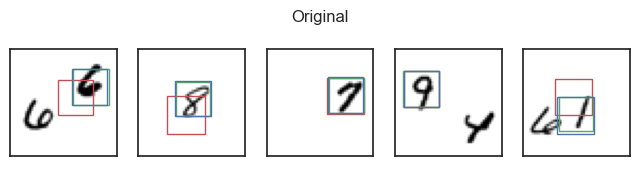

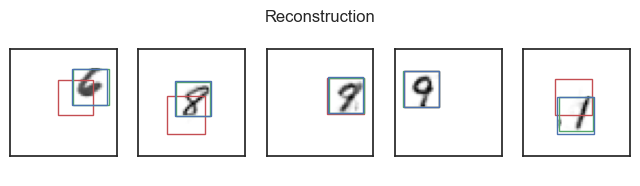

Epoch=16100, elapsed=3121.07, loss=628.20
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   97     1     1 19921]
 [    0     0     0 20032]]
Epoch=16200, elapsed=3140.18, loss=629.90
accuracy=0.33250001072883606, counts=[[19948     0     0     0]
 [   93     2     1 19924]
 [    0     0     0 20032]]
Epoch=16300, elapsed=3159.29, loss=632.28
accuracy=0.33246666193008423, counts=[[19948     0     0     0]
 [   93     0     3 19924]
 [    0     0     0 20032]]
Epoch=16400, elapsed=3178.41, loss=632.32
accuracy=0.33246666193008423, counts=[[19948     0     0     0]
 [   82     0     2 19936]
 [    0     0     0 20032]]
Epoch=16500, elapsed=3197.51, loss=632.91
accuracy=0.33248335123062134, counts=[[19947     1     0     0]
 [   90     2     0 19928]
 [    0     0     0 20032]]
Epoch=16600, elapsed=3216.65, loss=632.32
accuracy=0.3325166702270508, counts=[[19948     0     0     0]
 [   84     3     2 19931]
 [    0     0     0 20032]]
Epoch=16700, elapsed=3235.75, loss=

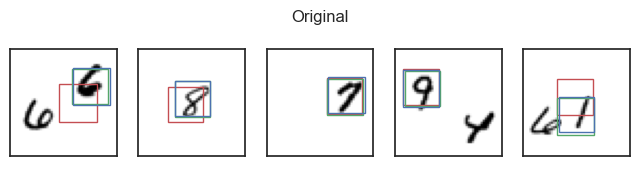

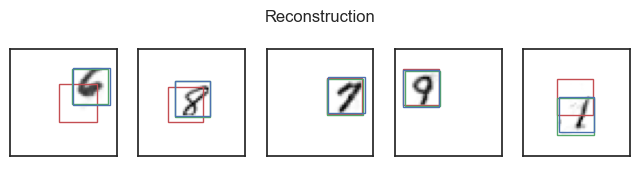

Epoch=17100, elapsed=3312.22, loss=630.86
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   82     1     2 19935]
 [    0     0     0 20032]]
Epoch=17200, elapsed=3331.36, loss=630.80
accuracy=0.33246666193008423, counts=[[19948     0     0     0]
 [   88     0     3 19929]
 [    0     0     0 20032]]
Epoch=17300, elapsed=3350.48, loss=632.26
accuracy=0.3325333297252655, counts=[[19948     0     0     0]
 [   88     4     0 19928]
 [    0     0     0 20032]]
Epoch=17400, elapsed=3369.63, loss=629.96
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   83     1     1 19935]
 [    0     0     0 20032]]
Epoch=17500, elapsed=3388.74, loss=631.81
accuracy=0.33250001072883606, counts=[[19948     0     0     0]
 [   81     2     0 19937]
 [    0     0     0 20032]]
Epoch=17600, elapsed=3407.87, loss=632.29
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   77     1     1 19941]
 [    0     0     0 20032]]
Epoch=17700, elapsed=3427.02, loss=

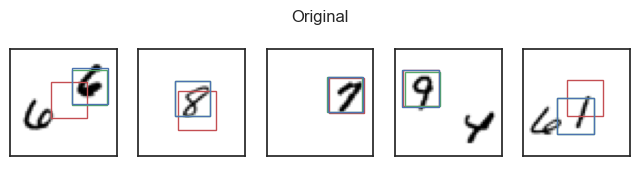

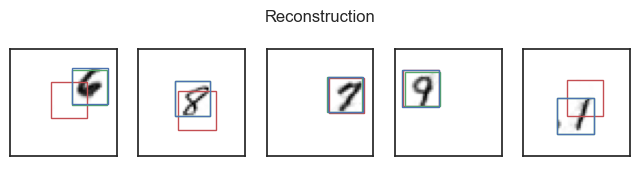

Epoch=18100, elapsed=3503.52, loss=631.50
accuracy=0.33246666193008423, counts=[[19948     0     0     0]
 [   76     0     0 19944]
 [    0     0     0 20032]]
Epoch=18200, elapsed=3522.58, loss=631.13
accuracy=0.33246666193008423, counts=[[19948     0     0     0]
 [   77     0     3 19940]
 [    0     0     0 20032]]
Epoch=18300, elapsed=3541.62, loss=631.38
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   73     1     1 19945]
 [    0     0     0 20032]]
Epoch=18400, elapsed=3560.68, loss=631.97
accuracy=0.33250001072883606, counts=[[19947     1     0     0]
 [   69     3     0 19948]
 [    0     0     0 20032]]
Epoch=18500, elapsed=3579.73, loss=631.16
accuracy=0.3325166702270508, counts=[[19948     0     0     0]
 [   65     3     1 19951]
 [    0     0     0 20032]]
Epoch=18600, elapsed=3598.75, loss=630.50
accuracy=0.33246666193008423, counts=[[19948     0     0     0]
 [   77     0     1 19942]
 [    0     0     0 20032]]
Epoch=18700, elapsed=3617.78, loss=

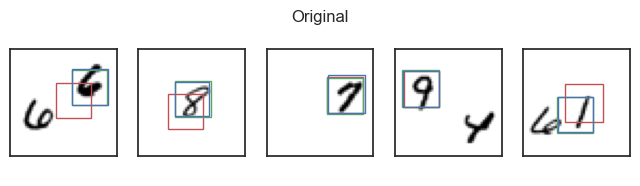

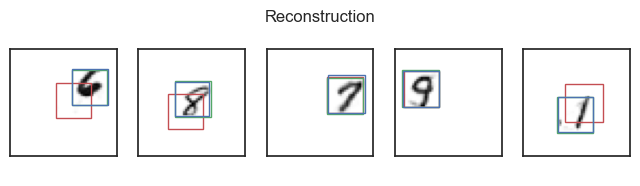

Epoch=19100, elapsed=3694.14, loss=631.88
accuracy=0.33250001072883606, counts=[[19948     0     0     0]
 [   68     2     2 19948]
 [    0     0     0 20032]]
Epoch=19200, elapsed=3713.23, loss=633.20
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   77     1     0 19942]
 [    0     0     0 20032]]
Epoch=19300, elapsed=3732.31, loss=633.20
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   69     1     0 19950]
 [    0     0     0 20032]]
Epoch=19400, elapsed=3751.43, loss=630.81
accuracy=0.33250001072883606, counts=[[19948     0     0     0]
 [   61     2     3 19954]
 [    0     0     0 20032]]
Epoch=19500, elapsed=3770.56, loss=631.45
accuracy=0.33248335123062134, counts=[[19948     0     0     0]
 [   65     1     3 19951]
 [    0     0     0 20032]]
Epoch=19600, elapsed=3789.65, loss=630.74
accuracy=0.33250001072883606, counts=[[19948     0     0     0]
 [   66     2     2 19950]
 [    0     0     0 20032]]
Epoch=19700, elapsed=3808.77, loss

In [17]:
batch_size = 32
learning_rate = 1.0e-3
num_epochs = 20000


def svi_update(model, guide, optimiser):
    def batch_updater(key, params, opt_state, data_batch):
        def grads(key, params, data):
            (decoder, rnn, encoder, predict) = params
            data = genjax.choice_map({"obs": data})
            objective = grasp.elbo(model, guide, data)
            loss, (
                (decoder_grads,),
                (_, rnn_grads, encoder_grads, predict_grads),
            ) = objective.value_and_grad_estimate(
                key, ((decoder,), (data, rnn, encoder, predict))
            )
            return loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads)

        sub_keys = jax.random.split(key, len(data_batch))
        loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads) = jax.vmap(
            grads, in_axes=(0, None, 0)
        )(sub_keys, params, data_batch)

        grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0),
            (decoder_grads, rnn_grads, encoder_grads, predict_grads),
        )
        updates, opt_state = optimiser.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss = jnp.mean(loss)
        return params, opt_state, loss

    return batch_updater


adam = optax.adam(learning_rate)
svi_updater = svi_update(model, guide, adam)
train_init, train_fetch = circular_data_loader(mnist, batch_size)
num_train, train_idx = train_init()


@jax.jit
def epoch_train(opt_state, params, key, train_idx):
    def body_fn(carry, xs):
        idx, params, opt_state, loss = carry
        updater_key = jax.random.fold_in(key, idx)
        batch = train_fetch(idx, train_idx)[0]
        params, opt_state, loss = svi_updater(updater_key, params, opt_state, batch)
        idx += 1
        return (idx, params, opt_state, loss), loss

    idx = 0
    (_, params, opt_state, _), losses = jax.lax.scan(
        body_fn, (idx, params, opt_state, 0.0), None, length=num_train
    )
    return params, opt_state, losses


# Train.
key = jax.random.PRNGKey(314159)
params = (decoder, rnn, encoder, predict)
opt_state = adam.init(params)
t0 = time.perf_counter()
losses = []
accuracy = []
for i in range(0, num_epochs):
    key, sub_key = jax.random.split(key)
    num_train, train_idx = train_init()
    params, opt_state, loss = epoch_train(opt_state, params, sub_key, train_idx)
    losses.extend(loss)
    if i % 100 == 0:
        elapsed = time.perf_counter() - t0
        print(f"Epoch={i}, elapsed={elapsed:.2f}, loss={jnp.mean(loss):.2f}")
        acc, counts, error_ix = evaluate_accuracy(sub_key, params[1:])
        accuracy.append(acc)
        print("accuracy={}, counts={}".format(acc, counts))
    if i % 1000 == 0:
        visualize(sub_key, params, visualize_examples)

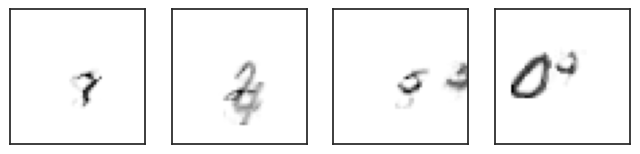

In [20]:
(trained_decoder, _, _, _) = params
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 4)
tr = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))(sub_keys, (trained_decoder,))
generated = tr.get_retval()
show_images(generated)

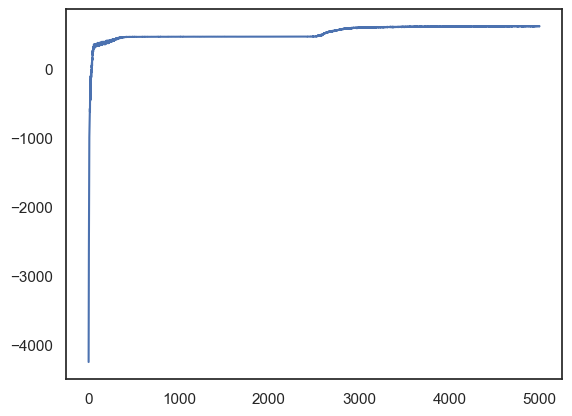

In [22]:
plt.plot(losses[:5000])